In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Project 2: Newton Methods

## Introduction

Given a set of $2$ test scores associated to each student in a current class, we want to predict through a simple model whether a student passes the course or not. We decide to use a linear model to separate who will pass from who will fail.

We use the historical test scores obtained from $m$ past students who passed/failed this course in previous years. We input these historical scores as $m$ data vectors such that $\overline{X}_i=(x_1^{(i)}, x_2^{(i)})$ contains the 2 midterm scores of the $i$th student $1\leq i \leq m$. We define a set of associated binary target values $y_i\in \{-1,+1\}$ ($+1$ passed, $-1$ failed) $1\leq i \leq m$. The goal then is to find an affine function

 
\begin{align*}
f(x_1, x_2)=w_1 x_1 + w_2 x_2+w_3=
\begin{pmatrix}
w_1 \\ 
w_2 \\ 
w_3
\end{pmatrix}\cdot
\begin{pmatrix}
x_1 \\ 
x_2 \\ 
1
\end{pmatrix}  =\overline{W}\cdot\overline{X}^T,
\end{align*}

so that $f$ may be used to predict the outcome of a different (yet unseen) score $(z_1,z_2)$ by 

\begin{align*}
f(z_1, z_2)<0&\rightarrow \text{fail}\\
f(z_1, z_2)>0&\rightarrow \text{pass}
\end{align*}


## Data set and associated Loss Functionals

Suppose you are given the historical data set in the cell/code snippet below


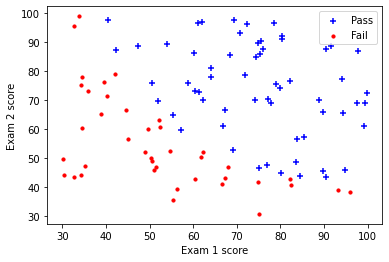

In [16]:
# Load and plot the data set
df=pd.read_csv("ex2data1.txt",header=None)
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values   
y=2*y-1 # the original y-values are 0,1 this makes them be -1 or 1. 

pos , neg = (y==1).reshape(100,1) , (y==-1).reshape(100,1)
plt.scatter(X[pos[:,0],0],X[pos[:,0],1],c="b",marker="+")
plt.scatter(X[neg[:,0],0],X[neg[:,0],1],c="r", marker="o", s =10)
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(["Pass","Fail"],loc=0)

 
Introduce the loss functionals
\begin{equation}\label{1}\tag{1}
J_1(\overline{W})=\sum_{i=1}^m (1-y_i \overline{W}\cdot\overline{X}_i^T)^2 \hspace{0.2in}
\big( \text{linear regression}\big)
\end{equation}
\begin{equation}\label{2}\tag{2}
J_2(\overline{W})=\sum_{i=1}^m \log(1+ e^{-y_i \overline{W}\cdot\overline{X}_i^T}) \hspace{0.2in}\big( \text{logistic regression}\big)
\end{equation}

\begin{equation}\label{3}\tag{3}
J_3(\overline{W})=\sum_{i=1}^m \log(1+ e^{-y_i \overline{W}\cdot\overline{X}_i^T}) +\frac{\lambda}{2}\|\overline{W}\|_2^2 \hspace{0.2in}\big( \text{regularized logistic regression}\big)
\end{equation}

## 1.  (40 pts)

Calculate the gradients and the Hessians of $J_1, J_2$ and $J_3$, and represent/program each of these as a Python function. Note your function should take as argument variables $\overline{W}$, input data points $\overline{X}_i$, and corresponding $y_i$ values. You can put all the $\overline{X}_i$ into a single $X$ (the $i$th row of $X$ is  $\overline{X}_i$) and all $y_i$ into a vector $y$, whose $i$th element is $y_i$. A possible function prototype outline is 

In [17]:
# Note students have to append the 1 to X

m , d = X.shape[0], X.shape[1]
X= np.append(np.ones((m,1)),X,axis=1)
y=y.reshape(m,1)

In [107]:
def CostLinReg(W, X, y): # 10 pts TOTAL correct CostLinReg
    """
    Takes in numpy array W, X and y and returns the corresponding cost function, gradient 
    and hessian  
    """
    
    # The W parameter is our initial Guess. X is the data matrix D in [Aggarwal] notation
    
    m=len(y)
    difference=X@W-y
    cost = 0.5*difference.T@difference # 2 pts
    grad = X.T@X@W-X.T@y # 4
    hess =X.T@X # 4pts
    
    return cost , grad, hess

In [108]:
 def sigmoid(z):
    return 1/ (1 + np.exp(-z))
    
def CostLogReg(W, X, y):  # 20 PTS TOTAL
    """
    Takes in numpy array W, X and y and returns the corresponding cost function, gradient 
    and hessian  
    """
    
    # The W parameter is our initial Guess. X is the data matrix D in [Aggarwal] notation
  
    # note below I use np.multiply(col,col)=col vector consisting of elementwise multiplication of arrays
    predictions = sigmoid(np.multiply(-y,np.dot(X,W))) #<---the matrix P in my Latex notes NOTE: np.multiply is elementwise!
    error =  -np.log(sigmoid(np.multiply(y,np.dot(X,W)))) #note it is -log(sigmoid), not log(sigmoid)! 
    P=np.diagflat(predictions)
    cost = sum(error)

    grad =  -X.T@P@y #10 pts gradient 
    hess = np.dot(X.T, predictions*(1-predictions)*X) #<---this was causing the probblem! #10 pts Hessian
 

    
    return cost, grad, hess

In [109]:
def CostLogR2Reg(W, lambd, X, y): #10 pts TOTAL
    """
    Takes in numpy array W, X and y and returns the corresponding cost function, gradient 
    and hessian  
    """
    d=W.shape[0]
    I=np.eye(d)
    # The W parameter is our initial Guess. X is the data matrix D in [Aggarwal] notation
    cost, grad, hess=CostLogReg(W,X,y)
    cost+=(lambd*W.T@W)[0]
    grad+=2*lambd*W
    hess+=2*lambd*I
 

    
    return cost, grad, hess

## 2. (10 pts)

Are these functionals convex? Explain.

## 3. (30 pts) 

Using the functions you wrote in part 1., implement Newton's method to find the approximate solutions to 

\begin{equation}
\nabla J_i(\overline{W})=0 \hspace{0.2in} \text{(the respective minima)}
\end{equation}

For a stopping criterion, use 

\begin{equation}
\frac{|J_i(\overline{W}_{k+1})-J_i(\overline{W}_{k})|}{J_i(\overline{W}_{k+1})} \leq 10^{-7}
\end{equation}

You may want to try different initial guesses $\overline{W}_0$, and you may want to try different (relatively small) values for $\lambda$ (the regularization parameter).

In [75]:
 # Your code here 
def newton_method(costFunction, X, y, W, tol=1e-8, max_it=100):
    num_it = 0
    cost_prev = 0
    rel_error=1
    cost, grad, hess = costFunction(W,X,y)
    while rel_error>=tol and num_it<max_it: # <---10 pts for putting correct tolerance in a WHILE loop
        # J(x) * delta = fun(x)  <==> delta = J^{-1}fun(x)
        cost_prev = cost
        print("cost is now: ", cost)
        delta = np.linalg.solve(hess, grad) # <---10pts correct delta to add to W_{k} to get W_{k+1} 
        W -= delta
        cost, grad, hess = costFunction(W,X,y) #<---reevaluate with new W 5 pts 
        rel_error = np.abs(cost-cost_prev)/cost #<---10 pts correct relative error with correct prev value
        num_it+=1
        print("Finished step ", num_it)
    if rel_error<tol:
            print('Newton method converges in %d iteration.' %num_it) #<
    else:
            print('Newton method does not converge in %d iteration.' %max_it)
            
    return W    

Cost of initial theta is [[913035.91676252]]
cost is now:  [[534.38553252]]
Finished step  1
cost is now:  [[18.89878625]]
Finished step  2
Newton method converges in 2 iteration.
lin regression W is  [[-3.59499387]
 [ 0.02968175]
 [ 0.02788434]]


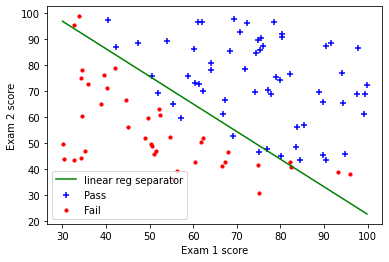

In [110]:
initial_W = np.ones((d+1,1))
cost, grad, hess= CostLinReg(initial_W,X,y)
print("Cost of initial theta is",cost)

W0 = newton_method(CostLinReg,X, y, initial_theta)
print('lin regression W is ', W0)

# plot decision boundary with parameters theta in part c)
 
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="b",marker="+")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="r", marker="o", s =10)
x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
y_value_lin_reg=-(W0[0] +W0[1]*x_value)/W0[2]
plt.plot(x_value,y_value_lin_reg, "g")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(["linear reg separator","Pass","Fail"],loc=0)


Cost of initial theta is [71.32616875]
cost is now:  [71.32616875]
Finished step  1
cost is now:  [29.86287778]
Finished step  2
cost is now:  [23.38033978]
Finished step  3
cost is now:  [20.92125495]
Finished step  4
cost is now:  [20.3837612]
Finished step  5
cost is now:  [20.3499451]
Finished step  6
cost is now:  [20.34977016]
Finished step  7
Newton method converges in 7 iteration.

******************************************** 
After Newton method: 
******************************************** 
Cost is [20.34977016]
W for logistic= [[-25.16133355]
 [  0.20623171]
 [  0.2014716 ]]


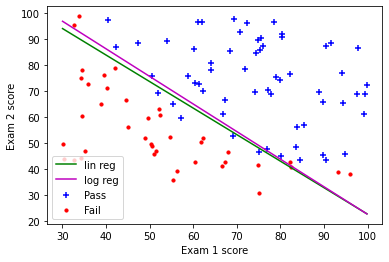

In [111]:

# Logistic regression cost function
initial_W = np.zeros((d+1,1))
initial_W[0]=1
initial_W[1]=0
initial_W[2]=0 
cost, grad, hess= CostLogReg(initial_W,X,y)
print("Cost of initial theta is",cost)
 

W_logistic = newton_method(CostLogReg,X, y, initial_W)


print("\n******************************************** ")
print("After Newton method: ")
print("******************************************** ")

new_cost, new_grad, new_hess= CostLogReg(W_logistic,X,y)
print("Cost is", new_cost)

print('W for logistic=', W_logistic)

# plot decision boundary for logistic AND LINEAR REG boundary to compare
 
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="b",marker="+")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="r", marker="o", s =10)
x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
y_value_log=-(W_logistic[0] +W_logistic[1]*x_value)/W_logistic[2]

plt.plot(x_value,y_value_log, "g")
plt.plot(x_value,y_value_lin_reg, "m")  #<---note I plot linear regression's separating line to compare
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(["lin reg", "log reg","Pass","Fail"],loc=0)


In [112]:
# Just for ease, since above functions don't require a lambda parameter and this regularized Tikhonov does.
# we modify its corresponding Newton method. Other options would have been something like if lambda=0 or
# if lambda=FALSE, call Newton in a certain manner and otherwise 

def newton_method2(costFunction, X, y, W, lambd, tol=1e-8, max_it=100):
    num_it = 0
    cost_prev = 0
    rel_error=1
    cost, grad, hess = costFunction(W, lambd, X,y)
    while rel_error>=tol and num_it<max_it:
        # J(x) * delta = fun(x)  <==> delta = J^{-1}fun(x)
        cost_prev = cost
        print("cost is now: ", cost)
        delta = np.linalg.solve(hess, grad)
        W -= delta
        cost, grad, hess = costFunction(W,lambd, X,y)
        rel_error = np.abs(cost-cost_prev)/cost
        num_it+=1
        print("Finished step ", num_it)
    if rel_error<tol:
            print('Newton method converges in %d iteration.' %num_it) #<
    else:
            print('Newton method does not converge in %d iteration.' %max_it)
            
    return W  

 

lambd=0.01

initial_theta = np.zeros((d+1,1))
cost, grad, hess= CostLogR2Reg(initial_theta, lambd,X,y)
print("Cost of initial theta is",cost)


W_r2 = newton_method2(CostLogR2Reg,X, y, initial_theta, lambd)


print("\n******************************************** ")
print("After Newton method: ")
print("******************************************** ")
 


print('W for Tikhonov logistic=', W_r2)
CostLogR2Reg(W_r2, lambd, X, y)


Cost of initial theta is [69.31471806]
cost is now:  [69.31471806]
Finished step  1
cost is now:  [33.92631157]
Finished step  2
cost is now:  [26.77844604]
Finished step  3
cost is now:  [24.80156875]
Finished step  4
cost is now:  [24.5929192]
Finished step  5
cost is now:  [24.59031405]
Finished step  6
cost is now:  [24.59031362]
Finished step  7
Newton method converges in 7 iteration.

******************************************** 
After Newton method: 
******************************************** 
W for Tikhonov logistic= [[-17.61811209]
 [  0.14597798]
 [  0.14042727]]


(array([24.59031362]),
 array([[-5.38458167e-15],
        [-3.51229896e-13],
        [-3.70549078e-13]]),
 array([[8.65611758e+00, 5.37018734e+02, 5.29685065e+02],
        [5.37018734e+02, 3.59635727e+04, 3.09516772e+04],
        [5.29685065e+02, 3.09516772e+04, 3.49898883e+04]]))

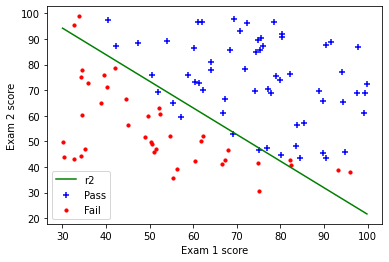

In [105]:
# plot decision boundary with parameters theta in part c)
 
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="b",marker="+")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="r", marker="o", s =10)
x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
y_value_r2=-(W_r2[0] +W_r2[1]*x_value)/W_r2[2]

plt.plot(x_value,y_value_r2, "g")
 
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(["r2","Pass","Fail"],loc=0)

## 4. (10 pts)

How many iterations were required for $J_1, J_2$ and $J_3$? Can you explain the count obtained for $J_1$?

ANSWER Q4: To get full marks, you must explain (3pts) 1 iteration (I give 2 pts for 2 iterations), and for the rest of points you must show you relate the gradient of $J_1$, $\nabla J_1(w)=X^T X w-X^T y$ and the Hessian $\text{Hess}(J_1)(w)= X^T X$ and plug it into the Newton iteration step $w_{k+1}=w_k-(\text{Hess}(J_1))^{-1}\nabla J_1(w_k)$

## 5. (10 pts)

Display the data with the "decision boundaries" obtained from the minimization of $J_1, J_2$ and $J_3$. 

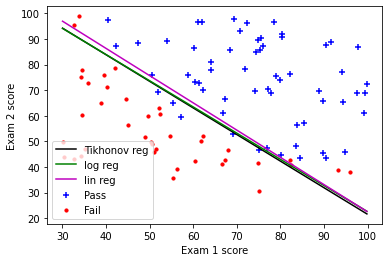

In [113]:
# Plot here

# plot decision boundary fo rALL to compare
 
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="b",marker="+")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="r", marker="o", s =10)
 
plt.plot(x_value,y_value_r2, "k")
plt.plot(x_value,y_value_log, "g")
plt.plot(x_value,y_value_lin_reg, "m")  #<---note I plot linear regression's separating line to compare
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(["Tikhonov reg", "log reg", "lin reg" , "Pass","Fail"],loc=0)


